In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns
import matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pickle
import warnings
warnings.filterwarnings("ignore")

## Vanilla

In [51]:
# RnC, + RnC on our most tailored RnC
# CF + CT
# policytree
# Our method (IPW, DM, DR)
# KPT, BPT -- need to reconfigure this
# add dumb predictor (assign everything majority class)

# open our methods first
df = pd.DataFrame()
for m in ['IPW', 'DM', 'DR']:
    df_buffer = pd.read_csv(f'Results_Warfarin_prob/compiled_results/{m}.csv')
    df_buffer = df_buffer[df_buffer['fairness'] == 1.0][['method', 'randomization', 'realized_outcome_oos']]
    
    if m == 'DR':
        m = 'DR (d=2)'
        df_buffer['method'] = m
    df = pd.concat([df, df_buffer], ignore_index=True)

    
# df = pd.concat([df, pd.DataFrame({'method': ['DR (d=2)'], 'Age': [0], 'Gender': ['M']}
             
# DR (d=3)
df_buffer = pd.read_csv(f'Results_Warfarin_prob/compiled_results/unconstrained_agg.csv')
df_buffer = df_buffer[(df_buffer['method'] == 'Robust') & (df_buffer['depth'] == 3)][['method', 'randomization', 
                                                                                      'best_found_test']].rename(columns={'best_found_test':
                                                                                                                         'realized_outcome_oos'})
df_buffer['method'] = 'DR (d=3)'
df_buffer['realized_outcome_oos'] /= 100
df = pd.concat([df, df_buffer], ignore_index=True)

# DR (d=4)
df_buffer = pd.read_csv(f'Results_Warfarin_prob/compiled_results/unconstrained_agg.csv')
df_buffer = df_buffer[(df_buffer['method'] == 'Robust') & (df_buffer['depth'] == 4)][['method', 'randomization', 
                                                                                      'best_found_test']].rename(columns={'best_found_test':
                                                                                                                         'realized_outcome_oos'})
df_buffer['method'] = 'DR (d=4)'
df_buffer['realized_outcome_oos'] /= 100
df = pd.concat([df, df_buffer], ignore_index=True)

for m, m_method in zip(['Kallus', 'Bertsimas'], ['K-PT', 'B-PT']):
    df_buffer = pd.read_csv(f'Results_Warfarin_prob/compiled_results/{m}.csv')
    df_buffer = df_buffer[['method', 'randomization', 'realized_outcome_oos']]
    df_buffer['method'] = m_method
    df = pd.concat([df, df_buffer], ignore_index=True)
    
# causal forest and trees
for m, m_name in zip(['cf', 'cf_untuned', 'ct'], ['CF', 'CF (untuned)', 'CT']):
    df_buffer = pd.read_csv(f'other_methods/results/CF/warfarin/{m}_baseline_raw.csv')
#     df_trans = pd.DataFrame(columns=['method', 'randomization', 'realized_outcome_oos'])
    for col, name in zip(['random', 'r0.06', 'r0.11'], ['0.33', 'r0.06', 'r0.11']):
        h = pd.DataFrame({'realized_outcome_oos': df_buffer[col].tolist()})
        h['method'] = m_name
        h['randomization'] = name
        df = pd.concat([df, h], ignore_index=False)

# policytree
df_buffer = pd.read_csv(f'other_methods/results/policytree/warfarin/raw_proba_old.csv')
for col, name in zip(['random', 'r0.06', 'r0.11'], ['0.33', 'r0.06', 'r0.11']):
    h = pd.DataFrame({'realized_outcome_oos': df_buffer[col].tolist()})
    h['method'] = 'PT'
    h['randomization'] = name
    df = pd.concat([df, h], ignore_index=False)
# print(df_buffer)
# # rnc lrrf    
# df_buffer = pd.read_csv(f'other_methods/results/RC/warfarin/lrrf.csv')
# for col in ['r0.06', 'r0.11']:
#     h = pd.DataFrame({'realized_outcome_oos': df_buffer[col].tolist()})
#     h['method'] = 'R&C (Best)'
#     h['randomization'] = col
#     df = pd.concat([df, h], ignore_index=False)

# # rnc
# df_buffer = pd.read_csv(f'other_methods/results/RC/warfarin/raw.csv')
# df_buffer = df_buffer.rename(columns={'oopt': 'realized_outcome_oos'})
# df_buffer = df_buffer[df_buffer['method'].isin(['logit_balanced', 'rf_balanced'])][['method', 'randomization', 
#                                                                                                  'realized_outcome_oos']]

# df_buffer1 = df_buffer[(df_buffer['method'] == 'rf_balanced') & (df_buffer['randomization'] == '0.33')]
# df_buffer1['method'] = 'R&C (Best)'

# df_buffer['method'] = df_buffer['method'].map({'logit_balanced': 'R&C (Log)', 'rf_balanced': 'R&C (RF)'})

# df = pd.concat([df, df_buffer1], ignore_index=False)
# df = pd.concat([df, df_buffer], ignore_index=False)

In [52]:
df_buffer = pd.read_csv(f'other_methods/results/RC/warfarin/rc_raw.csv')

In [53]:
df_buffer_random = df_buffer[df_buffer['randomization'] == '0.33']
df_buffer_random1 = df_buffer_random[df_buffer_random['model'] == 'balanced_rf']
df_buffer_random1['model'] = 'best'
df_buffer_random = pd.concat([df_buffer_random[df_buffer_random['model'] != 'lrrf'], df_buffer_random1], ignore_index=True)
df_buffer_random['model'] = df_buffer_random['model'].map({'balanced_rf': 'R&C (RF)', 'best': 'R&C (Best)',
                                                          'balanced_lr': 'R&C (Log)'})

df_buffer_other = df_buffer[df_buffer['randomization'] != '0.33']
df_buffer_other['model'] = df_buffer_other['model'].map({'balanced_rf': 'R&C (RF)', 'lrrf': 'R&C (Best)',
                                                          'balanced_lr': 'R&C (Log)'})

df_buffer = pd.concat([df_buffer_random, df_buffer_other], ignore_index=True).rename(columns={'model': 'method',
                                                                                              'oosp': 'realized_outcome_oos'})

df = pd.concat([df, df_buffer[['method', 'randomization', 'realized_outcome_oos']]], ignore_index=False)

    randomization  dataset  seed        model  oos_regret      oosp  \
75          r0.06        1     1  balanced_rf         353  0.745310   
76          r0.06        1     1         lrrf         216  0.844156   
77          r0.06        1     1  balanced_lr         388  0.720058   
78          r0.06        1     2  balanced_rf         217  0.843434   
79          r0.06        1     2         lrrf         152  0.890332   
..            ...      ...   ...          ...         ...       ...   
220         r0.11        5     4         lrrf         273  0.803030   
221         r0.11        5     4  balanced_lr         188  0.864358   
222         r0.11        5     5  balanced_rf         218  0.842713   
223         r0.11        5     5         lrrf         213  0.846320   
224         r0.11        5     5  balanced_lr         202  0.854257   

     solve_time  
75     0.832407  
76     0.941791  
77     0.123528  
78     0.842095  
79     0.925717  
..          ...  
220    1.612537  
221

In [54]:
df['realized_outcome_oos'] = df['realized_outcome_oos']*100

In [55]:
df[['randomization', 'method', 'realized_outcome_oos']].groupby(['randomization', 'method']).agg('mean')

realized_outcome_oos
randomization method                            
0.33          B-PT                     72.860029
              CF                       86.216450
              CF (untuned)             86.216450
              CT                       85.171717
              DM                       84.580087
              DR (d=2)                 84.502165
              DR (d=3)                 86.014430
              DR (d=4)                 87.333333
              IPW                      84.476190
              K-PT                     84.629149
              PT                       84.380952
              R&C (Best)               90.193362
              R&C (Log)                89.766234
              R&C (RF)                 90.193362
r0.06         B-PT                     48.141414
              CF                       74.574315
              CF (untuned)             47.922078
              CT                       58.701299
              DM                       79.549784
              DR (d=2)                 78.764791
              DR (d=3)                 82.470418
              DR (d=4)                 84.054834
              IPW                      74.155844
              K-PT                     52.955267
              PT                       79.621934
              R&C (Best)               84.095238
              R&C (Log)                78.155844
              R&C (RF)                 80.248196
r0.11         B-PT                     48.828283
              CF                       73.307359
              CF (untuned)             48.432900
              CT                       56.701299
              DM                       73.362193
              DR (d=2)                 76.187590
              DR (d=3)                 78.917749
              DR (d=4)                 82.952381
              IPW                      72.669553
              K-PT                     49.402597
              PT                       73.575758
              R&C (Best)               76.816739
              R&C (Log)                75.483405
              R&C (RF)                 74.669553

In [56]:
colors = ["#FFC7C7", "#FFA4A4", "#EB6262", "#E32D2D", "#C81C1C",
         "#BFBFBF", "#878787",
         "#9CCF9B", "#67D165", "#21C51D",
          "#CCDA2F",
         "#B1B0CD", "#7B79CF", "#4543C0"]
# Set your custom color palette
customPalette = sns.color_palette(colors)

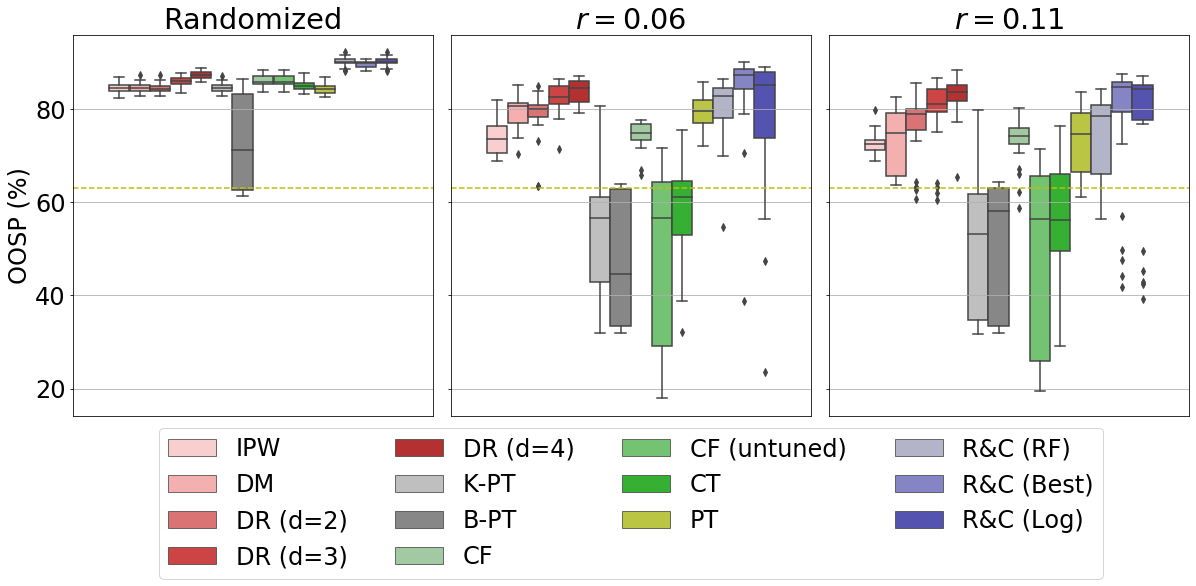

In [57]:
matplotlib.rcParams.update({'font.size': 24})
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 7), sharey=True)
for i, r in enumerate(['0.33', 'r0.06', 'r0.11']):
    sns.boxplot(data=df[df['randomization'] == r], y='realized_outcome_oos', x='randomization', hue='method', ax=ax[i],
               palette=customPalette)
    ax[i].axhline(y = 0.63*100, color = 'y', linestyle = '--')
    if i == 0:
        ax[i].set_ylabel('OOSP (%)')
        ax[i].set_title('Randomized')
    else:
        ax[i].set_ylabel('')
        if i == 1:
            ax[i].set_title(r'$r = 0.06$')
        elif i == 2:
            ax[i].set_title(r'$r = 0.11$')
        
    ax[i].set_xlabel('')
    ax[i].set_xticks([])

    if i == 1:
        ax[i].legend(bbox_to_anchor=(0.5, -0.23), ncol=4, loc='center')
    else:
        leg = ax[i].get_legend()
        leg.remove()
        
    ax[i].grid(visible=True, which='major', axis='y')
plt.subplots_adjust(wspace=0.05)
# plt.savefig('figs/warfarin_main.pdf', bbox_inches='tight')
plt.show()

In [62]:
color_order

{'IPW': '#FFC7C7',
 'DM': '#FFA4A4',
 'DR (d=2)': '#EB6262',
 'DR (d=3)': '#E32D2D',
 'DR (d=4)': '#C81C1C',
 'K-PT': '#BFBFBF',
 'B-PT': '#878787',
 'CF': '#9CCF9B',
 'CF (untuned)': '#67D165',
 'CT': '#21C51D',
 'PT': '#F3F646',
 'R&C (best)': '#B1B0CD',
 'R&C (Log)': '#7B79CF',
 'R&C (RF)': '#4543C0'}

In [11]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

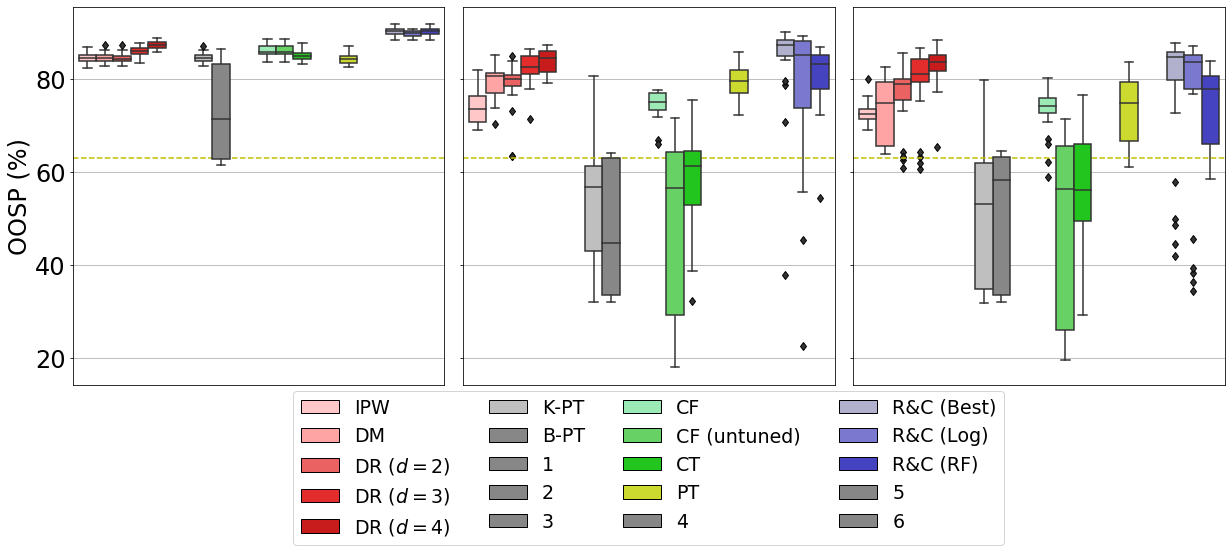

In [21]:
matplotlib.rcParams.update({'font.size': 24})
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 7), sharey=True)
for i, r in enumerate(['0.33', 'r0.06', 'r0.11']):
    
    subset = df[df['randomization'] == r]
    
    order=['IPW', 'DM', 'DR (d=2)', 'DR (d=3)', 'DR (d=4)',
                                'K-PT', 'B-PT',
                                'CF', 'CF (untuned)', 'CT', 'PT',
                                'R&C (Best)', 'R&C (Log)', 'R&C (RF)']
    positions = [1, 1.6, 2.2, 2.8, 3.4, 5, 5.6, 7.2, 7.8, 8.4, 10, 11.6, 12.2, 12.8]
    dic_order = {k: v for k, v in zip(order, positions)}
    sorted_dict = {key: value for key, value in sorted(dic_order.items())}
    colors = ["#FFC7C7", "#FFA4A4", "#EB6262", "#E32D2D", "#C81C1C",
         "#BFBFBF", "#878787",
         "#9CEAB6", "#67D165", "#21C51D",
          "#CCDA2F",
         "#B1B0CD", "#7B79CF", "#4543C0"]
    
    color_order = {k: v for k, v in zip(order, colors)}
    
    order_dummy=['IPW', 'DM', r'DR ($d=2$)', r'DR ($d=3$)', r'DR ($d=4$)',
                                'K-PT', 'B-PT', '1', '2', '3',
                                'CF', 'CF (untuned)', 'CT', 'PT', '4',
                                'R&C (Best)', 'R&C (Log)', 'R&C (RF)', '5', '6']
    colors_dummy = ["#FFC7C7", "#FFA4A4", "#EB6262", "#E32D2D", "#C81C1C",
         "#BFBFBF", "#878787", "#878787", "#878787", "#878787",
         "#9CEAB6", "#67D165", "#21C51D",
          "#CCDA2F", "#878787",
         "#B1B0CD", "#7B79CF", "#4543C0", "#878787", "#878787"]
    color_order_legend = {k: v for k, v in zip(order_dummy, colors_dummy)}
    legend_elements = [Patch(facecolor=v, label=k, linewidth=1, edgecolor='black') for k, v in color_order_legend.items()]
    
    sorted_dict_colors = {key: value for key, value in sorted(color_order.items())}
    
    bplot = subset.boxplot(by='method', column='realized_outcome_oos',
                          positions=list(sorted_dict.values()),
                          grid=False, patch_artist=True, ax=ax[i], sym='d', return_type='dict', widths=0.6)

#     Style boxplot
#     print(bplot['realized_outcome_oos']['boxes'])
    for patch, color in zip(bplot['realized_outcome_oos']['boxes'], list(sorted_dict_colors.values())):
        patch.set_facecolor(color)
        patch.set_edgecolor('0.2')
        patch.set_linewidth(1.5)
    for whisker in bplot['realized_outcome_oos']['whiskers']:
        whisker.set_color('0.2')
        whisker.set_linewidth(1.5)
    for fliers in bplot['realized_outcome_oos']['fliers']:
        fliers.set_markerfacecolor('0.2')
    for median in bplot['realized_outcome_oos']['medians']:
        median.set_color('0.2')
        median.set_linewidth(1.5)
    for caps in bplot['realized_outcome_oos']['caps']:
        caps.set_color('0.2')
        caps.set_linewidth(1.5)
    
#     xticklabels = ax[i].get_xticklabels()
#     ax[i].set_xticklabels(xticklabels, rotation = 45, ha="right")
    ax[i].axhline(y = 0.63*100, color = 'y', linestyle = '--')
    ax[i].set_xticks([])
    ax[i].set_xlabel('')
    ax[i].grid(visible=True, which='major', axis='y')
    ax[i].set_title('')
    if i == 0:
        ax[i].set_ylabel('OOSP (%)')
#         ax[i].set_title('Randomized')
    else:
        ax[i].set_ylabel('')
        if i == 1:
#             ax[i].set_title(r'$r = 0.06$')
            ax[i].legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.22), prop={'size': 19}, ncol=4, loc='center')
#         elif i == 2:
#             ax[i].set_title(r'$r = 0.11$')
            
plt.suptitle('')

plt.subplots_adjust(wspace=0.05)
plt.savefig('figs/warfarin_main.pdf', bbox_inches='tight')
plt.show()

In [113]:
df = pd.DataFrame()

df_buffer = pd.read_csv(f'Results_Warfarin_prob/compiled_results/unconstrained_agg.csv')
df_buffer = df_buffer[(df_buffer['method'] == 'Robust') & (df_buffer['depth'] == 2)][['method', 'randomization', 
                                                                                  'best_found_train']].rename(columns={'best_found_train':
                                                                                                                     'realized_outcome_train'})
    
df_buffer['method'] = 'DR (d=2) (train)'
df = pd.concat([df, df_buffer], ignore_index=True)

df_buffer = pd.read_csv(f'Results_Warfarin_prob/compiled_results/unconstrained_agg.csv')
df_buffer = df_buffer[(df_buffer['method'] == 'Robust') & (df_buffer['depth'] == 2)][['method', 'randomization', 
                                                                                  'best_found_test']].rename(columns={'best_found_test':
                                                                                                                     'realized_outcome_train'})
    
df_buffer['method'] = 'DR (d=2) (test)'
df = pd.concat([df, df_buffer], ignore_index=True)

    
df_buffer = pd.read_csv(f'other_methods/results/policytree/warfarin/raw_proba_training.csv')
for col, name in zip(['random', 'r0.06', 'r0.11'], ['0.33', 'r0.06', 'r0.11']):
    h = pd.DataFrame({'realized_outcome_train': df_buffer[col].tolist()})
    h['method'] = 'PT (train)'
    h['randomization'] = name
    h['realized_outcome_train'] *= 100
    df = pd.concat([df, h], ignore_index=False)
    
df_buffer = pd.read_csv(f'other_methods/results/policytree/warfarin/raw_proba_old.csv')
for col, name in zip(['random', 'r0.06', 'r0.11'], ['0.33', 'r0.06', 'r0.11']):
    h = pd.DataFrame({'realized_outcome_train': df_buffer[col].tolist()})
    h['method'] = 'PT (test)'
    h['randomization'] = name
    h['realized_outcome_train'] *= 100
    df = pd.concat([df, h], ignore_index=False)

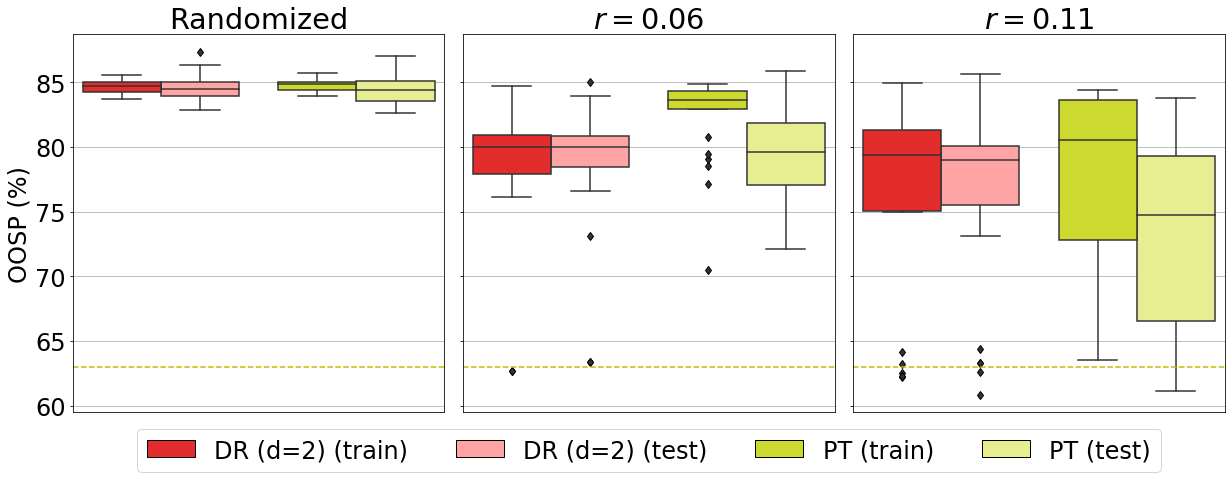

In [123]:
matplotlib.rcParams.update({'font.size': 24})
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 7), sharey=True)
for i, r in enumerate(['0.33', 'r0.06', 'r0.11']):
    
    subset = df[df['randomization'] == r]
    
    order=['DR (d=2) (train)', 'DR (d=2) (test)', 'PT (train)', 'PT (test)']
    positions = [1, 1.8, 3, 3.8]
    dic_order = {k: v for k, v in zip(order, positions)}
    sorted_dict = {key: value for key, value in sorted(dic_order.items())}
    colors = ["#E32D2D", "#FFA4A4",
          "#CCDA2F", "#E7EE92"]
    
    color_order = {k: v for k, v in zip(order, colors)}
    legend_elements = [Patch(facecolor=v, label=k, linewidth=1, edgecolor='black') for k, v in color_order.items()]
    
    sorted_dict_colors = {key: value for key, value in sorted(color_order.items())}
    
    bplot = subset.boxplot(by='method', column='realized_outcome_train',
                          positions=list(sorted_dict.values()),
                          grid=False, patch_artist=True, ax=ax[i], sym='d', return_type='dict', widths=0.8)

#     Style boxplot
#     print(bplot['realized_outcome_oos']['boxes'])
    for patch, color in zip(bplot['realized_outcome_train']['boxes'], list(sorted_dict_colors.values())):
        patch.set_facecolor(color)
        patch.set_edgecolor('0.2')
        patch.set_linewidth(1.5)
    for whisker in bplot['realized_outcome_train']['whiskers']:
        whisker.set_color('0.2')
        whisker.set_linewidth(1.5)
    for fliers in bplot['realized_outcome_train']['fliers']:
        fliers.set_markerfacecolor('0.2')
    for median in bplot['realized_outcome_train']['medians']:
        median.set_color('0.2')
        median.set_linewidth(1.5)
    for caps in bplot['realized_outcome_train']['caps']:
        caps.set_color('0.2')
        caps.set_linewidth(1.5)
    
#     xticklabels = ax[i].get_xticklabels()
#     ax[i].set_xticklabels(xticklabels, rotation = 45, ha="right")
    ax[i].axhline(y = 0.63*100, color = 'y', linestyle = '--')
    ax[i].set_xticks([])
    ax[i].set_xlabel('')
    ax[i].grid(visible=True, which='major', axis='y')
    if i == 0:
        ax[i].set_ylabel('OOSP (%)')
        ax[i].set_title('Randomized')
    else:
        ax[i].set_ylabel('')
        if i == 1:
            ax[i].set_title(r'$r = 0.06$')
            ax[i].legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.1), prop={'size': 24}, ncol=4, loc='center')
        elif i == 2:
            ax[i].set_title(r'$r = 0.11$')
            
plt.suptitle('')

plt.subplots_adjust(wspace=0.05)
plt.savefig('figs/warfarin_overfit.pdf', bbox_inches='tight')
plt.show()

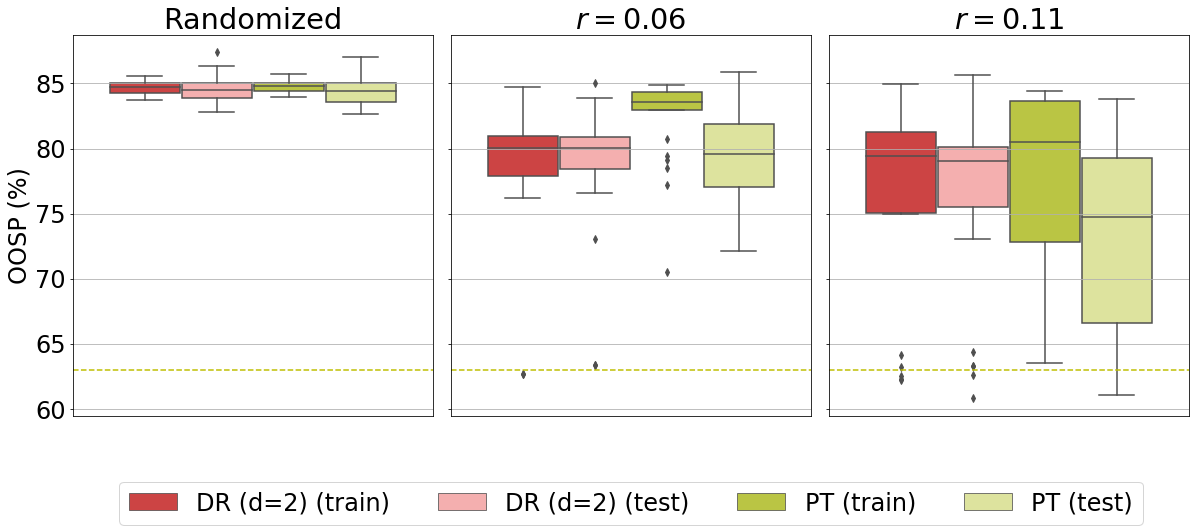

In [115]:
colors = ["#E32D2D", "#FFA4A4",
          "#CCDA2F", "#E7EE92"]
# Set your custom color palette
customPalette = sns.color_palette(colors)
matplotlib.rcParams.update({'font.size': 24})
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 7), sharey=True)
for i, r in enumerate(['0.33', 'r0.06', 'r0.11']):
    sns.boxplot(data=df[df['randomization'] == r], y='realized_outcome_train', x='randomization', hue='method', ax=ax[i],
               palette=customPalette)
    ax[i].axhline(y = 0.63*100, color = 'y', linestyle = '--')
    if i == 0:
        ax[i].set_ylabel('OOSP (%)')
        ax[i].set_title('Randomized')
    else:
        ax[i].set_ylabel('')
        if i == 1:
            ax[i].set_title(r'$r = 0.06$')
        elif i == 2:
            ax[i].set_title(r'$r = 0.11$')
        
    ax[i].set_xlabel('')
    ax[i].set_xticks([])

    if i == 1:
        ax[i].legend(bbox_to_anchor=(0.5, -0.23), ncol=4, loc='center')
    else:
        leg = ax[i].get_legend()
        leg.remove()
        
    ax[i].grid(visible=True, which='major', axis='y')
plt.subplots_adjust(wspace=0.05)
# plt.savefig('figs/warfarin_main.pdf', bbox_inches='tight')
plt.show()

In [110]:
df = pd.DataFrame()

df_buffer = pd.read_csv(f'Results_Warfarin_prob/compiled_results/unconstrained_agg.csv')
df_buffer = df_buffer[(df_buffer['method'] == 'Robust') & (df_buffer['depth'] == 2)][['method', 'randomization', 
                                                                                  'best_found_test']].rename(columns={'best_found_test':
                                                                                                                     'realized_outcome_train'})
    
df_buffer['method'] = 'DR (d=2)'
df = pd.concat([df, df_buffer], ignore_index=True)
    
df_buffer = pd.read_csv(f'other_methods/results/policytree/warfarin/raw_proba_old.csv')
for col, name in zip(['random', 'r0.06', 'r0.11'], ['0.33', 'r0.06', 'r0.11']):
    h = pd.DataFrame({'realized_outcome_train': df_buffer[col].tolist()})
    h['method'] = 'PT'
    h['randomization'] = name
    h['realized_outcome_train'] *= 100
    df = pd.concat([df, h], ignore_index=False)

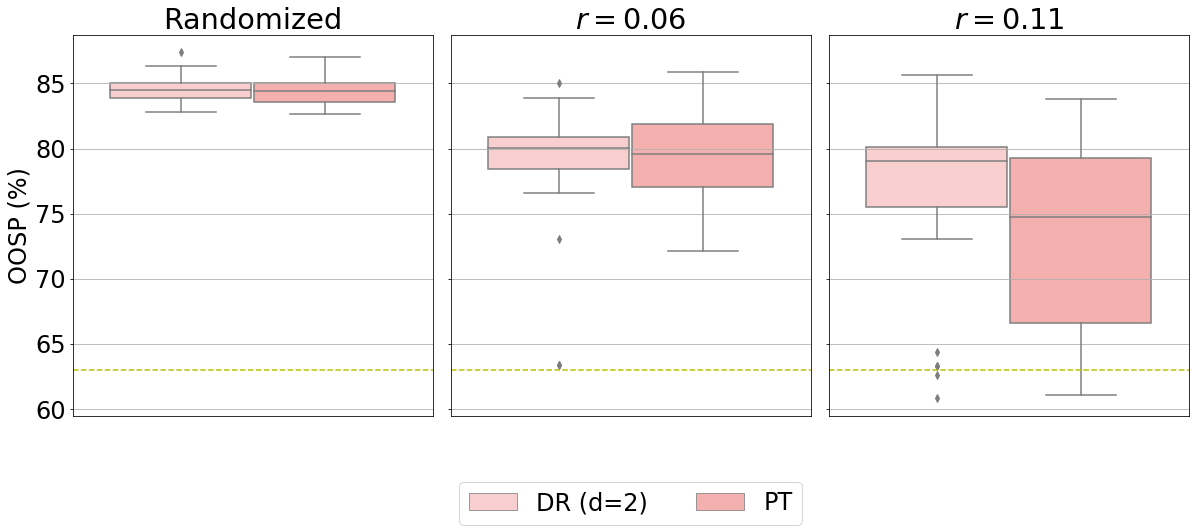

In [111]:
matplotlib.rcParams.update({'font.size': 24})
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 7), sharey=True)
for i, r in enumerate(['0.33', 'r0.06', 'r0.11']):
    sns.boxplot(data=df[df['randomization'] == r], y='realized_outcome_train', x='randomization', hue='method', ax=ax[i],
               palette=customPalette)
    ax[i].axhline(y = 0.63*100, color = 'y', linestyle = '--')
    if i == 0:
        ax[i].set_ylabel('OOSP (%)')
        ax[i].set_title('Randomized')
    else:
        ax[i].set_ylabel('')
        if i == 1:
            ax[i].set_title(r'$r = 0.06$')
        elif i == 2:
            ax[i].set_title(r'$r = 0.11$')
        
    ax[i].set_xlabel('')
    ax[i].set_xticks([])

    if i == 1:
        ax[i].legend(bbox_to_anchor=(0.5, -0.23), ncol=4, loc='center')
    else:
        leg = ax[i].get_legend()
        leg.remove()
        
    ax[i].grid(visible=True, which='major', axis='y')
plt.subplots_adjust(wspace=0.05)
# plt.savefig('figs/warfarin_main.pdf', bbox_inches='tight')
plt.show()

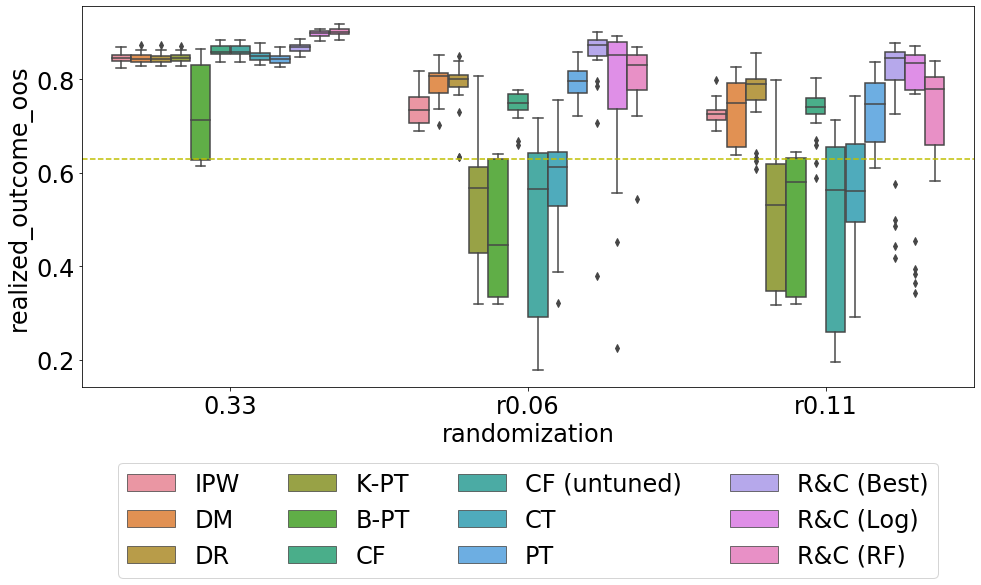

In [18]:
matplotlib.rcParams.update({'font.size': 24})
plt.figure(figsize=(16, 7))
sns.boxplot(data=df, y='realized_outcome_oos', x='randomization', hue='method')
plt.axhline(y = 0.63, color = 'y', linestyle = '--')
plt.legend(bbox_to_anchor=(0.5, -0.35), ncol=4, loc='center')
plt.show()

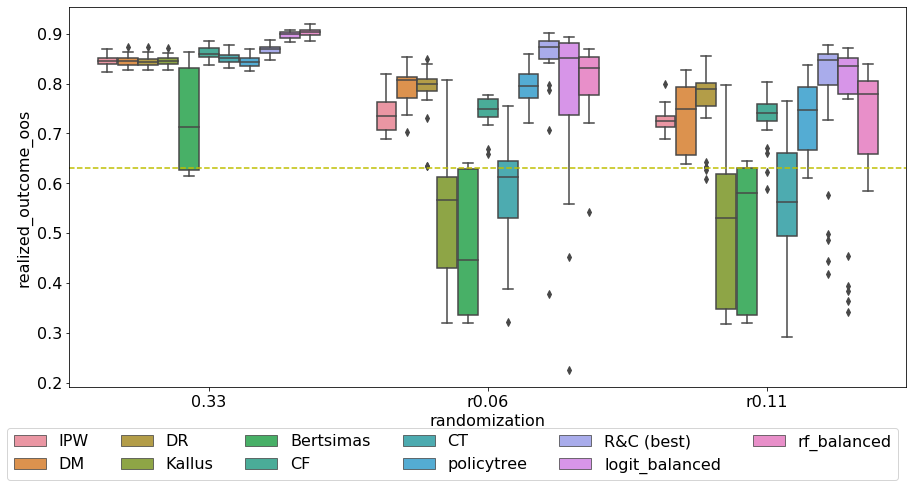

In [109]:
plt.figure(figsize=(15, 7))
sns.boxplot(data=df, y='realized_outcome_oos', x='randomization', hue='method')
plt.axhline(y = 0.63, color = 'y', linestyle = '--')
# plt.legend(bbox_to_anchor=(1.05, 1))
plt.legend(bbox_to_anchor=(1, -0.085), ncol=6)
plt.show()

## Fairness Constraints

### NO NEED TO RE-RUN: just load in CSV

In [ ]:
def split_d1(row, branching, leaves):
    if row[branching[0]] == 0:
        return row[f'y{leaves[0]}']
    else:
        return row[f'y{leaves[1]}']
    
def split_d1_prob(row, branching, leaves):
    if row[branching[0]] == 0:
        return row[f'y{np.random.choice(np.arange(2), p=list(leaves[0].values()))}']
    else:
        return row[f'y{np.random.choice(np.arange(2), p=list(leaves[1].values()))}']
    
def split_d2(row, branching, leaves):
    if row[branching[0]] == 0:
        if row[branching[1]] == 0:
            return row[f'y{leaves[0]}']
        else:
            return row[f'y{leaves[1]}']
    else:
        if row[branching[2]] == 0:
            return row[f'y{leaves[2]}']
        else:
            return row[f'y{leaves[3]}']

def split_d2_prob_coinflip(row, branching, leaves):
    if row[branching[0]] == 0:
        if row[branching[1]] == 0:
            return row[f'y{np.random.choice(np.arange(3), p=list(leaves[0].values()))}']
        else:
            return row[f'y{np.random.choice(np.arange(3), p=list(leaves[1].values()))}']
    else:
        if row[branching[2]] == 0:
            return row[f'y{np.random.choice(np.arange(3), p=list(leaves[2].values()))}']
        else:
            return row[f'y{np.random.choice(np.arange(3), p=list(leaves[3].values()))}']
        
def split_d2_prob(row, branching, leaves):
    if row[branching[0]] == 0:
        if type(branching[1]) == dict:
            return np.sum(branching[1][k] * row[f'y{k}'] for k in range(3))
        else:
            if row[branching[1]] == 0:
                return np.sum(leaves[0][k] * row[f'y{k}'] for k in range(3))
            else:
                return np.sum(leaves[1][k] * row[f'y{k}'] for k in range(3))
    else:
        if type(branching[2]) == dict:
            return np.sum(branching[2][k] * row[f'y{k}'] for k in range(3))
        else:
            if row[branching[2]] == 0:
                return np.sum(leaves[2][k] * row[f'y{k}'] for k in range(3))
            else:
                return np.sum(leaves[3][k] * row[f'y{k}'] for k in range(3))
        
def split_d3(row, branching, leaves):
    if row[branching[0]] == 0:
        if 'pruned' not in branching[1]:
            if row[branching[1]] == 0:
                if 'pruned' not in branching[3]:
                    if row[branching[3]] == 0:
                        return row[f'y{leaves[0]}']
                    else:
                        return row[f'y{leaves[1]}']
                else:
                    return row[f'y{branching[3][-1]}']
            else:
                if 'pruned' not in branching[4]:
                    if row[branching[4]] == 0:
                        return row[f'y{leaves[2]}']
                    else:
                        return row[f'y{leaves[3]}']
                else:
                    return row[f'y{branching[4][-1]}']
        else:
            return row[f'y{branching[1][-1]}']
    else:
        if 'pruned' not in branching[2]:
            if row[branching[2]] == 0:
                if 'pruned' not in branching[5]:
                    if row[branching[5]] == 0:
                        return row[f'y{leaves[4]}']
                    else:
                        return row[f'y{leaves[5]}']
                else:
                    return row[f'y{branching[5][-1]}']
            else:
                if 'pruned' not in branching[6]:
                    if row[branching[6]] == 0:
                        return row[f'y{leaves[6]}']
                    else:
                        return row[f'y{leaves[7]}']
                else:
                    return row[f'y{branching[6][-1]}']
        else:
            return row[f'y{branching[2][-1]}']
            
def assign_d1(row, branching, leaves):
    if row[branching[0]] == 0:
        return int(leaves[0])
    else:
        return int(leaves[1])
    
def assign_d1_prob(row, branching, leaves):
    if row[branching[0]] == 0:
        return np.random.choice(np.arange(2), p=list(leaves[0].values()))
    else:
        return np.random.choice(np.arange(2), p=list(leaves[1].values()))
    
def assign_d2(row, branching, leaves):
    if row[branching[0]] == 0:
        if row[branching[1]] == 0:
            return int(leaves[0])
        else:
            return int(leaves[1])
    else:
        if row[branching[2]] == 0:
            return int(leaves[2])
        else:
            return int(leaves[3])
        
def assign_d2_prob_coinflip(row, branching, leaves):
    if row[branching[0]] == 0:
        if row[branching[1]] == 0:
            return np.random.choice(np.arange(3), p=list(leaves[0].values()))
        else:
            return np.random.choice(np.arange(3), p=list(leaves[1].values()))
    else:
        if row[branching[2]] == 0:
            return np.random.choice(np.arange(3), p=list(leaves[2].values()))
        else:
            return np.random.choice(np.arange(3), p=list(leaves[3].values()))
        
def assign_d2_prob(row, branching, leaves):
    if row[branching[0]] == 0:
        if type(branching[1]) == dict:
            return branching[1]
        else:
            if row[branching[1]] == 0:
                return leaves[0]
            else:
                return leaves[1]
    else:
        if type(branching[2]) == dict:
            return branching[2]
        else:
            if row[branching[2]] == 0:
                return leaves[2]
            else:
                return leaves[3]
        
def assign_d3(row, branching, leaves):
    if row[branching[0]] == 0:
        if 'pruned' not in branching[1]:
            if row[branching[1]] == 0:
                if 'pruned' not in branching[3]:
                    if row[branching[3]] == 0:
                        return int(leaves[0])
                    else:
                        return int(leaves[1])
                else:
                    return int(branching[3][-1])
            else:
                if 'pruned' not in branching[4]:
                    if row[branching[4]] == 0:
                        return int(leaves[2])
                    else:
                        return int(leaves[3])
                else:
                    return int(branching[4][-1])
        else:
            return int(branching[1][-1])
    else:
        if 'pruned' not in branching[2]:
            if row[branching[2]] == 0:
                if 'pruned' not in branching[5]:
                    if row[branching[5]] == 0:
                        return int(leaves[4])
                    else:
                        return int(leaves[5])
                else:
                    return int(branching[5][-1])
            else:
                if 'pruned' not in branching[6]:
                    if row[branching[6]] == 0:
                        return int(leaves[6])
                    else:
                        return int(leaves[7])
                else:
                    return int(branching[6][-1])
        else:
            return int(branching[2][-1])

In [ ]:
method = 'DM' # 'DR'
seeds = range(1, 6)
splits = range(1, 6)
randomizations = ['0.33', 'r0.06', 'r0.11']
if method == 'DM':
    bounds = [1.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]
else:
    bounds = [1.0, 0.02, 0.01, 0.05, 0.06]

In [ ]:
sensitive_group = 'White'

warfarin_outcome = pd.DataFrame(columns=['seed', 'split', 'randomization', 'white_realized_outcome_oos', 'non_white_realized_outcome_oos', 
                                         'realized_outcome_oos', 'white_dr_outcome', 'non_white_dr_outcome', 'dr_outcome', 'tree_depth', 'tree', 'fairness', 'method'])
missing = []

for r in randomizations:
    ml = 'lrrf'
    if r != '0.33':
        ml = 'lrrf'
    else:
        ml = 'ml'
    for seed in seeds:
        for split in splits:
            fp_data = f'../data/Warfarin_v2/rf_balance_proba_white/seed{seed}'
            df_train = pd.read_csv(os.path.join(fp_data, f'data_train_enc_{r}_{split}.csv'))
            df_test = pd.read_csv(os.path.join(fp_data, f'data_test_enc_{r}_{split}.csv'))

            df_train_raw = pd.read_csv(os.path.join(fp_data, f'data_train_{r}_{split}.csv'))
            df_test_raw = pd.read_csv(os.path.join(fp_data, f'data_test_{r}_{split}.csv'))

            df_test['White'] = df_test.apply(lambda row: 1 if row['Asian'] == 0 and row['Black.or.African.American'] == 0 \
                                            and row['Unknown.Race'] == 0 else 0, axis=1)
            
            for bound in bounds:
                # THIS IS FOR DM
#                 if method == 'DM':
#                     if r == '0.33' and (bound < 0.09 and bound > 0.03):
#                         continue
#                     if r == 'r0.11' and bound < 0.05:
#                         continue
#                     if r == 'r0.06' and bound < 0.03:
#                         continue
#                 else:
#                     if r == '0.33' and (bound < 0.09 and bound > 0.03):
#                         continue
#                     if r != '0.33' and bound < 0.05:
#                         continue
                        
                if method == 'DR':
                    if r == '0.33' and (bound < 0.09 and bound > 0.03):
                        continue
                    if r != '0.33' and bound < 0.05:
                        continue
                
                tree = {}
                d=2
                if method == 'DM':
                    fp = f'DM/fairness/seed{seed}/data_train_enc_{r}_{split}_Direct_d_{d}_t_10800_branching_limit_100.0_pred_tree_ml_{ml}_White_{bound}.p'
                else:
                    fp = f'Robust/new2/seed{seed}/data_train_enc_{r}_{split}_Robust_d_{d}_t_10800_branching_limit_100.0_pred_tree_ml_{ml}_White_{bound}.p'

                if os.path.exists(fp):
                    with open(fp, 'rb') as f:
                        tree[d] = pickle.load(f)
                else:
                    missing.append(fp)
                    continue
                        

                df_test['y_d2'] = df_test.apply(lambda row: split_d2_prob(row, tree[2]['branching'], tree[2]['leaves']), axis=1)
                df_train['t_d2'] = df_train.apply(lambda row: assign_d2_prob(row, tree[2]['branching'], tree[2]['leaves']), axis=1)
                df_train['nu_ki'] = df_train.apply(lambda row: row[f"{ml}{int(row['t'])}"], axis=1)

                for d in [2]:
                    df_train[f'nu_pi_d{d}'] = df_train.apply(lambda row: np.sum(row[f't_d{d}'][k] * row[f"{ml}{k}"] for k in range(3)), axis=1)
                    if method == 'DM':
                        df_train[f'dr_d{d}'] = df_train[f'nu_pi_d{d}']
                    else:
                        df_train['same_t_buffer'] = df_train.apply(lambda row: row[f't_d{d}'][int(row['t'])], axis=1)
                        df_train[f'dr_d{d}'] = (df_train['y'] - df_train['nu_ki']) * ((df_train['same_t_buffer'])/df_train['prob_t_pred_tree']) + df_train[f'nu_pi_d{d}']
                    
                    white_realized_outcome, non_white_realized_outcome = evaluate_disparity(df_test, sensitive_group, f'y_d{d}')
                    white_dr_outcome, non_white_dr_outcome = evaluate_disparity(df_train, sensitive_group, f'dr_d{d}')
                    realized_outcome = df_test['y_d2'].mean()
                    dr_outcome = df_train['dr_d2'].mean()
                    warfarin_outcome.loc[len(warfarin_outcome)] = [seed, split, r, white_realized_outcome, non_white_realized_outcome, 
                                                                   realized_outcome, white_dr_outcome, non_white_dr_outcome, dr_outcome, d, tree[d], bound, method]

In [ ]:
warfarin_outcome['dr_disparity'] = warfarin_outcome['white_dr_outcome'] - warfarin_outcome['non_white_dr_outcome']
warfarin_outcome['realized_disparity'] = warfarin_outcome['white_realized_outcome_oos'] - warfarin_outcome['non_white_realized_outcome_oos']

### START HERE to load in from CSV

In [2]:
warfarin_outcome = pd.read_csv('Results_Warfarin_prob/compiled_results/DM.csv')

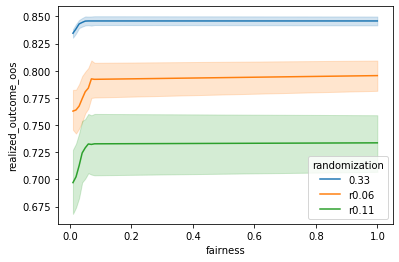

In [7]:
sns.lineplot(data=warfarin_outcome, x='fairness', y='realized_outcome_oos', hue='randomization')
plt.show()

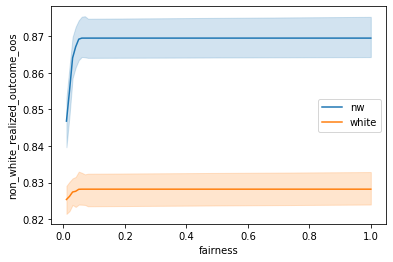

In [13]:
subset = warfarin_outcome[warfarin_outcome['randomization'] == '0.33']
sns.lineplot(data=subset, x='fairness', y='non_white_realized_outcome_oos', label='nw')
sns.lineplot(data=subset, x='fairness', y='white_realized_outcome_oos', label='white')
plt.legend()
plt.show()

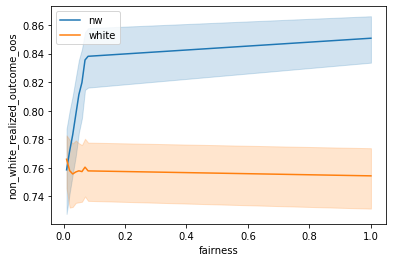

In [14]:
subset = warfarin_outcome[warfarin_outcome['randomization'] == 'r0.06']
sns.lineplot(data=subset, x='fairness', y='non_white_realized_outcome_oos', label='nw')
sns.lineplot(data=subset, x='fairness', y='white_realized_outcome_oos', label='white')
plt.legend()
plt.show()

In [3]:
warfarin_outcome['']

,seed,split,randomization,white_realized_outcome_oos,non_white_realized_outcome_oos,realized_outcome_oos,white_dr_outcome,non_white_dr_outcome,dr_outcome,tree_depth,tree,fairness,method,dr_disparity,realized_disparity
0,1,1,0.33,0.825436,0.880137,0.848485,0.832084,0.864089,0.846017,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Weight...",1.00,DM,-0.032005,-0.054701
1,1,1,0.33,0.830811,0.862535,0.844178,0.831448,0.841448,0.835801,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Age3.4...",0.01,DM,-0.010000,-0.031724
2,1,1,0.33,0.831671,0.873288,0.849206,0.832621,0.851593,0.840880,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Age3.4...",0.02,DM,-0.018972,-0.041617
3,1,1,0.33,0.825283,0.877779,0.847402,0.831833,0.861833,0.844893,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Weight...",0.03,DM,-0.030000,-0.052496
4,1,1,0.33,0.825436,0.880137,0.848485,0.832084,0.864089,0.846017,2,"{'branching': ['VKORC1.A.A', 'X.2..3', 'Weight...",0.04,DM,-0.032005,-0.054701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,5,5,r0.11,0.708176,0.672231,0.692849,0.721797,0.761797,0.739117,2,"{'branching': ['Age5.6', 'Weight3', 'Asian'], ...",0.04,DM,-0.040000,0.035945
671,5,5,r0.11,0.708176,0.696925,0.703378,0.721797,0.771797,0.743447,2,"{'branching': ['Age5.6', 'Weight3', 'Asian'], ...",0.05,DM,-0.050000,0.011252
672,5,5,r0.11,0.715676,0.714118,0.713908,0.721797,0.781797,0.747777,2,"{'branching': ['Age5.6', 'Weight3', 'Asian'], ...",0.06,DM,-0.060000,0.001558
673,5,5,r0.11,0.715676,0.738811,0.724437,0.721797,0.791797,0.752107,2,"{'branching': ['Age5.6', 'Weight3', 'Asian'], ...",0.07,DM,-0.070000,-0.023135


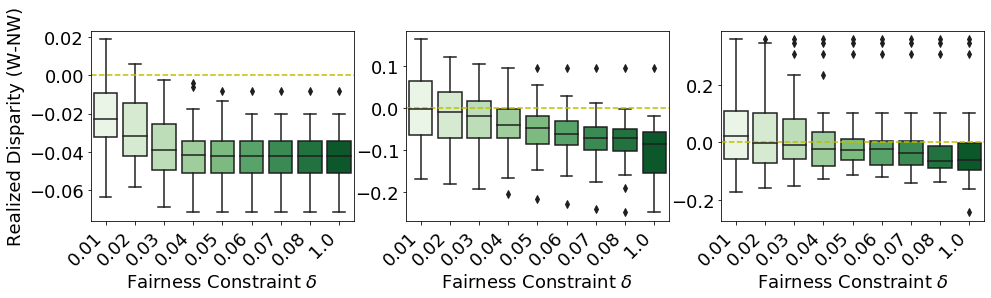

In [5]:
matplotlib.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(1, 3, figsize=(16, 3.5))

for i, r in enumerate(['0.33', 'r0.06', 'r0.11']):
    subset = warfarin_outcome[warfarin_outcome['randomization'] == r]
    sns.boxplot(data=subset, y='realized_disparity', x='fairness', ax=ax[i], palette="Greens")
#     ax[i].set_title(f'{r}')
    if i != 0:
        ax[i].set_ylabel('')
    else:
        ax[i].set_ylabel('Realized Disparity (W-NW)')
    ax[i].set_xlabel(r'Fairness Constraint $\delta$')
    ax[i].axhline(y = 0, color = 'y', linestyle = '--')
    ax[i].set_xticklabels([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 1.0], rotation = 45, ha="right")

plt.subplots_adjust(wspace=0.2)
plt.savefig('figs/fairness_warfarin.pdf', bbox_inches='tight')
plt.show()

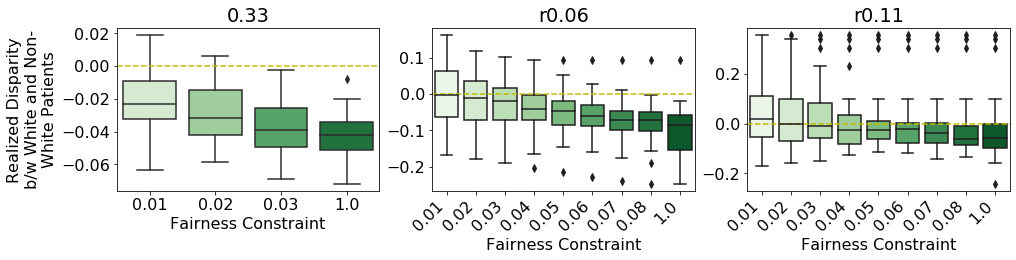

In [87]:
matplotlib.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1, 3, figsize=(16, 3))

for i, r in enumerate(['0.33', 'r0.06', 'r0.11']):
    if i == 0:
#         print(r)
        subset = warfarin_outcome[(warfarin_outcome['randomization'] == '0.33') & \
                                  ((warfarin_outcome['fairness'] <= 0.03) | (warfarin_outcome['fairness'] == 1.0))]
#         print(subset['randomization'].value_counts())
    else:
        subset = warfarin_outcome[warfarin_outcome['randomization'] == r]
    sns.boxplot(data=subset, y='realized_disparity', x='fairness', ax=ax[i], palette="Greens")
    ax[i].set_title(f'{r}')
    if i != 0:
        ax[i].set_ylabel('')
    else:
        ax[i].set_ylabel('Realized Disparity\nb/w White and Non-\nWhite Patients')
    ax[i].set_xlabel('Fairness Constraint')
    ax[i].axhline(y = 0, color = 'y', linestyle = '--')
    if r != '0.33':
        ax[i].set_xticklabels([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 1.0], rotation = 45, ha="right")
    
plt.subplots_adjust(wspace=0.2)
plt.show()